<a href="https://colab.research.google.com/github/ErickLimAce/appweb1/blob/main/Wine_Classification_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación con Regresión Logística - Dataset de Vinos

El Challenge se soluciona usando el dataset de vinos distribuido en la semana 1 (wine)


In [117]:
from google.colab import drive
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Me salia un warning acerca de la versión de sklearn
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn')

# Cargar el dataset
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/IA/wine.data")
winenames = ['Class','Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
data.columns = winenames
#df = pd.read_csv("/content/drive/MyDrive/IA/wine.csv")
data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


## El dataset se divide en entrenamiento y prueba

In [118]:
#variable dependiente target
X = data.drop("Class", axis=1)
y = data["Class"]
#print(df['Class'].value_counts())
#entrenamiento y prueba(30), stratify para desbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=None)


# Se desarrolla un modelo de regresión logística que utilice una característica que el alumno considere relevante, no relevante y la union
## Relevante Flavanoids(esencial para la estructura, complejidad y capacidad de envejecimiento del vino)
## No Relevante Ash(No afecta directamente el sabor)

In [119]:
X_relevant = X_train[["Flavanoids"]]
X_not_relevant = X_train[["Ash"]]
X_both = X_train[["Flavanoids", "Ash"]]
y_train = y_train


## Función para entrenar y evaluar modelos

In [163]:
results = {}

def train_and_evaluate(X_train, y_train, X_test, y_test, label):
    model = LogisticRegression(penalty= 'l2', multi_class='auto', solver= 'lbfgs',max_iter=1000, random_state=None)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred,labels=[1, 2, 3] ) #labels=[1, 2, 3]
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, average='weighted',zero_division=0) #zero_division=0 por warning
    re = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results[label] = {"cm": cm, "accuracy": acc, "precision": pre,"recall": re,"f1_score": f1, "model": model}
    return None


## Entrenamiento de modelos
Relevante, no relevante, ambos y ambos+cuadrado



In [164]:
X_test_relevant = X_test[["Flavanoids"]]
X_test_not_relevant = X_test[["Ash"]]
X_test_both = X_test[["Flavanoids", "Ash"]]

train_and_evaluate(X_relevant, y_train, X_test_relevant, y_test, "Relevante (Flavanoids)")
train_and_evaluate(X_not_relevant, y_train, X_test_not_relevant, y_test, "No relevante (Ash)")
train_and_evaluate(X_both, y_train, X_test_both, y_test, "Ambas")
#de scikit-learn PolynomialFeature para cuadrados
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_both)
X_test_poly = poly.transform(X_test_both)
train_and_evaluate(X_train_poly, y_train, X_test_poly, y_test, "Ambas + cuadrados")


## Visualización de matrices de confusión

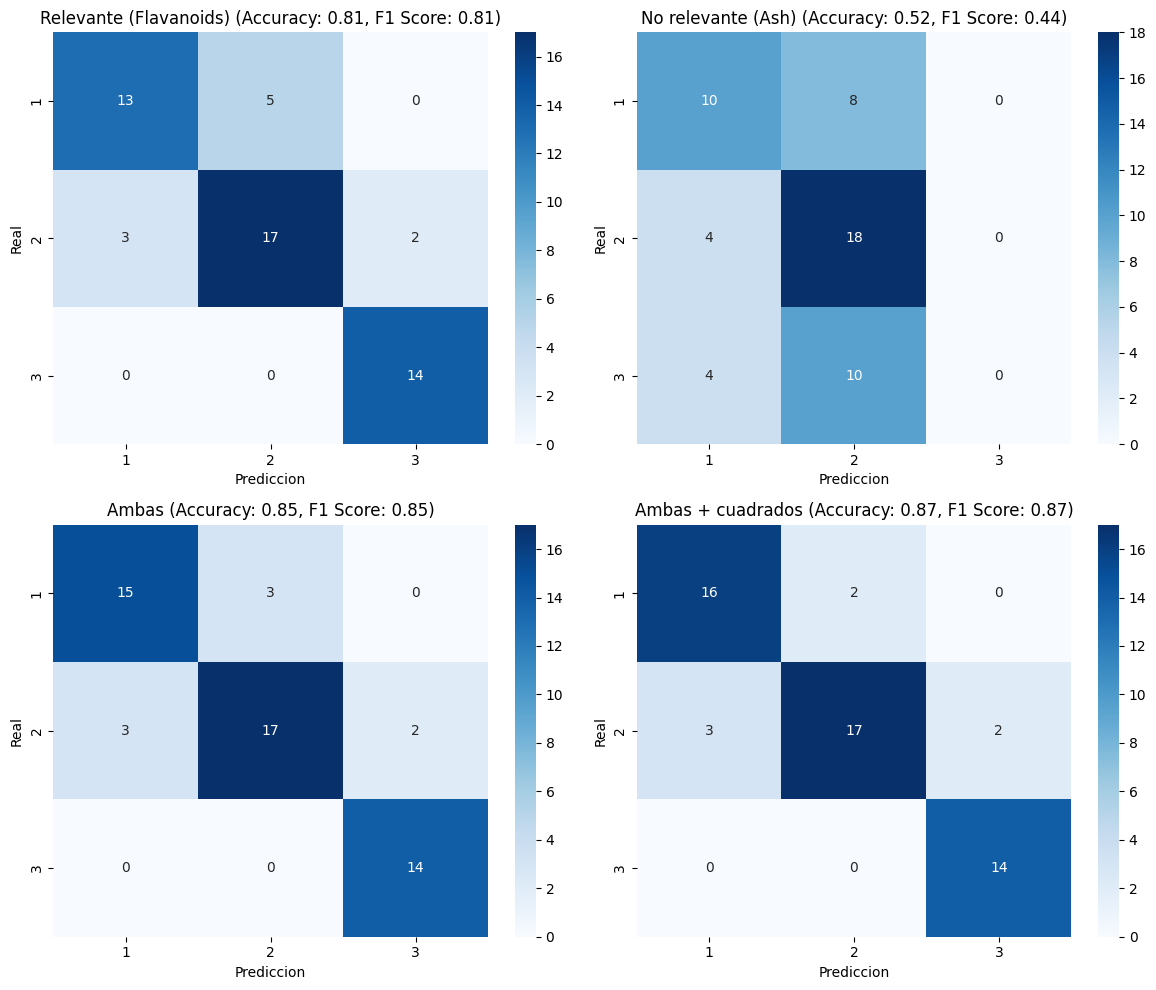

In [167]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
for idx, (title, data) in enumerate(results.items()):
    sns.heatmap(data["cm"], annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
    axes[idx].set_title(f"{title} (Accuracy: {data['accuracy']:.2f}, F1 Score: {data['f1_score']:.2f})") #f1=pr y re
    axes[idx].set_xlabel("Prediccion")
    axes[idx].set_ylabel("Real")
plt.tight_layout()
plt.show()


## Comparación de resultados

In [139]:
for label, data in results.items():
    print(f"{label}")
    for metric, value in data.items():
        if metric not in ["model", "cm"]: # QUita model y cm
            print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")
    print("---------------------")

Relevante (Flavanoids)
acc: 0.8148
precision: 0.8125
recall: 0.8148
f1_score: 0.8117
---------------------
No relevante (Ash)
acc: 0.5185
precision: 0.3889
recall: 0.5185
f1_score: 0.4381
---------------------
Ambas
acc: 0.8519
precision: 0.8509
recall: 0.8519
f1_score: 0.8496
---------------------
Ambas + cuadrados
acc: 0.8704
precision: 0.8721
recall: 0.8704
f1_score: 0.8681
---------------------


## Selección del mejor modelo

In [169]:
best_model = max(results.items(), key=lambda x: x[1]["accuracy"])
print(f"Mejor modelo: {best_model[0]} con accuracy de {best_model[1]['accuracy']:.2f}")


Mejor modelo: Ambas + cuadrados con accuracy de 0.87


## Validación en entrenamiento y prueba

In [103]:
model = best_model[1]["model"]
if "cuadrados" in best_model[0].lower():
    xtrain = X_train_poly
    xtest = X_test_poly
elif "ambas" in best_model[0].lower():
    xtrain = X_both
    xtest = X_test_both
elif "no relevante" in best_model[0].lower():
    xtrain = X_not_relevant
    xtest = X_test_not_relevant
else:
    xtrain = X_relevant
    xtest = X_test_relevant

print("Accuracy en entrenamiento:", accuracy_score(y_train, model.predict(xtrain)))
print("Accuracy en prueba:", accuracy_score(y_test, model.predict(xtest)))


Accuracy en entrenamiento: 0.8130081300813008
Accuracy en prueba: 0.7962962962962963


## Conclusión


El modelo si que resultó útil para clasificar vinos, realmente fue porque busque características relevantes como lo son Flavanoids.
Aunque Ash sea "irrelevante", puede contener pequeñas señales útiles que complementan a Flavanoids.Pude ver que incluso variables poco relevantes pueden aportar información marginal a la hora de realizar este analisis y si a esto le sumas la unión.
Las matrices de confusión mostraron una mejora clara al aumentar la complejidad del modelo, la capacidad para capturar relaciones entre las características y las clases aumentó un 6%.